# RegTech Session: Transaction monitoring 

This session present an example focusing on transaction monitoring on an abstract level. We cover the following topis:

* Model of a transaction system
* Classical transaction schemes.
* Detection based on node-properties
* Detection based on transaction structures
* Limitations and Challenges


In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

from transaction_laboratory import transactionLaboratory
from schemes import random_behavior, layering, round_tripping

### Examples of transaction-based crime

Transaction-based crime is the core of compliance monitoring. In general, the aim of this crime is to pass funds or goods originating from illegal behavior. Examples of transaction-based crime include:

- Money laundering: 
- Sanction evasion:
- Credit card fraud:
- ...

### Research Question

Consider a set of users, some of which control multiple accounts, passing transactions around. Some transactions are compliant and some are non-compliant. How do we tell compliant from non-compliant ones?

### Abstraction of behavior

Transaction patterns differ from one case to another. However, certain different criminals can have the same ideas on how to pass illicitly obtained funds or goods. For example, layering is a relatively basic approach, as illustrated bellow 

## Random behavior, Layering, and Round Tripping

In [2]:
#set up agents

#non-compliant agents performing layering
N_lr_intermediate_accounts = 5
lr_accounts = {
    'source_account': 'SL',
    'intermediate_accounts': ['IL' + str(i) for i in range(N_lr_intermediate_accounts)],
    'target_account': 'TL'
}
lr = layering(lr_accounts)

#non-compliant agents performing round tripping
N_rt_source_accounts, N_rt_intermediate_accounts, N_rt_target_accounts = 10, 25, 4
rt_accounts = {
    'source_accounts': ['S' + str(i) for i in range(N_rt_source_accounts)],
    'intermediate_accounts': ['I' + str(i) for i in range(N_rt_intermediate_accounts)],
    'target_accounts': ['T' + str(i) for i in range(N_rt_target_accounts)]
}
rt = round_tripping(rt_accounts)

#all acounts
N_ra = 500
compliant_accounts = ['C' + str(i) for i in range(N_ra)]
noncompliant_accounts = lr.noncompliant_accounts + rt.noncompliant_accounts
allAccounts = compliant_accounts + noncompliant_accounts

#random compliant agents
rb = random_behavior(allAccounts)

In [3]:
df_rb = rb.generate(k = 30000)
df_lr = lr.generate(amount_per_send = 9999)
df_rt = rt.generate(max_intermediate_transactions = 30, capital=5*10**6)

df = pd.concat([df_rb, df_lr, df_rt])
df = df.sort_values('time')
print(df.shape)
df.head(10)

(39406, 4)


,source,target,amount,time
2149,S7,I8,1208.88,2025-03-01 08:00:00
2260,S0,I21,7026.33,2025-03-01 08:00:00
6369,S9,I19,16960.26,2025-03-01 08:00:00
6370,I19,I12,16960.26,2025-03-01 08:00:00
4535,S2,I3,17606.84,2025-03-01 08:00:00
1912,S8,I15,10624.97,2025-03-01 08:00:00
6697,S1,I6,1782.58,2025-03-01 08:00:00
3570,S8,I6,216.15,2025-03-01 08:00:00
3571,I6,I19,216.15,2025-03-01 08:00:00
4992,S3,I9,19890.48,2025-03-01 08:00:00


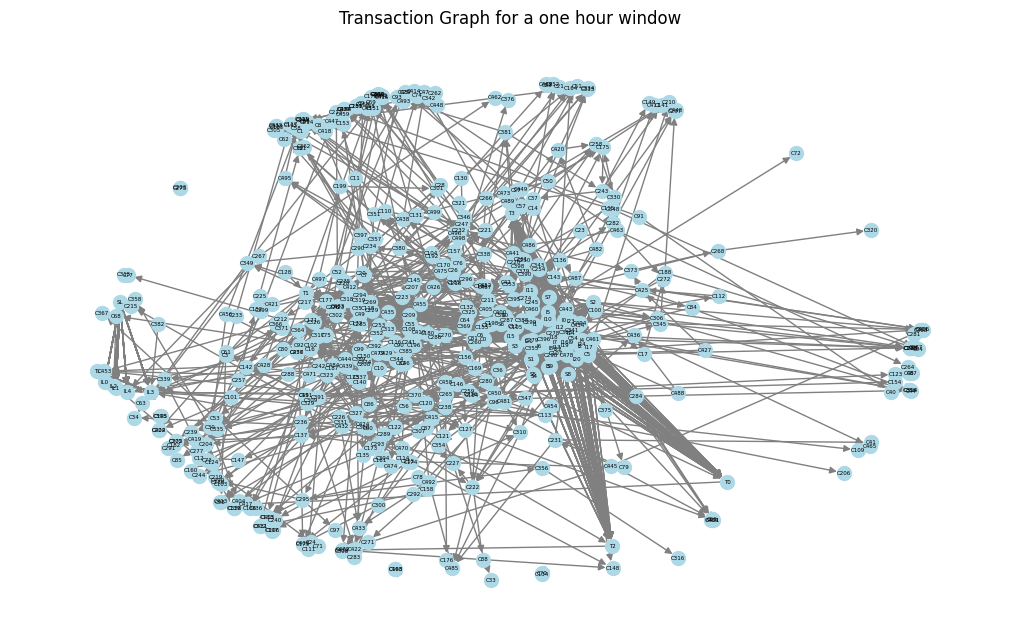

In [4]:
tmp = df.loc[df['time'] < datetime(2025, 3, 1, 9, 0, 0)]
rb.plotTransactionGraph(tmp, edgeLables=False, title="Transaction Graph for a one hour window") #TODO: maybe make this plot animated in time

## Detection

### Rule-based approach

<Axes: >

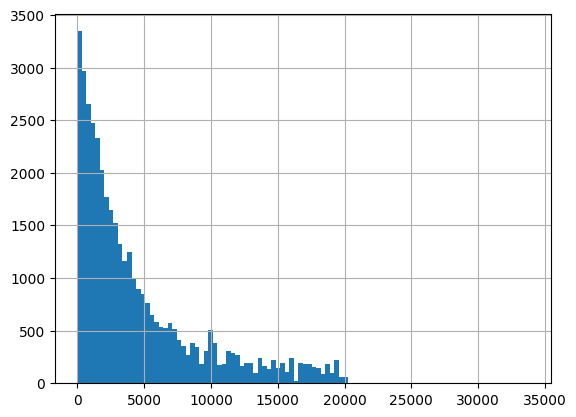

In [5]:
df['amount'].hist(bins = 100)

In [6]:
from collections import Counter

#identifying all transactions with suspicious amount
def getSuspects(df, lower_th = 9900, upper_th = 10000):
    df_suspects = df.loc[(df['amount'] > lower_th) & (df['amount'] < upper_th)] 
    suspects = df_suspects['source'].to_list() + df_suspects['target'].to_list()

    #counting how many times the account engaged in a transaction that triggered a rule match
    suspects = pd.Series({id: count/len(suspects) for id, count in Counter(suspects).items()}).to_frame('Risk')
    #suspects.sort_values('Risk', ascending=False)
    return suspects

#setting a threshold by which we define what frequency of matches is significant
def thresholdSuspects(suspects, threshold):
    return list(suspects.loc[suspects['Risk'] > threshold].index)

suspects = getSuspects(df)
high_risk_suspects = thresholdSuspects(suspects, 0.1)

In [7]:
def getConfusionTable(noncompliant_prediction, compliant_prediction, compliant_accounts, noncompliant_accounts):
    TP = len(set(noncompliant_prediction).intersection(noncompliant_accounts))
    TN = len(set(compliant_prediction).intersection(compliant_accounts))
    FP = len(set(noncompliant_prediction).intersection(compliant_accounts))
    FN = len(set(compliant_prediction).intersection(noncompliant_accounts))
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
    
not_suspects = list((set(allAccounts) - set(high_risk_suspects)))

getConfusionTable(high_risk_suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 2, 'TN': 500, 'FP': 0, 'FN': 44}

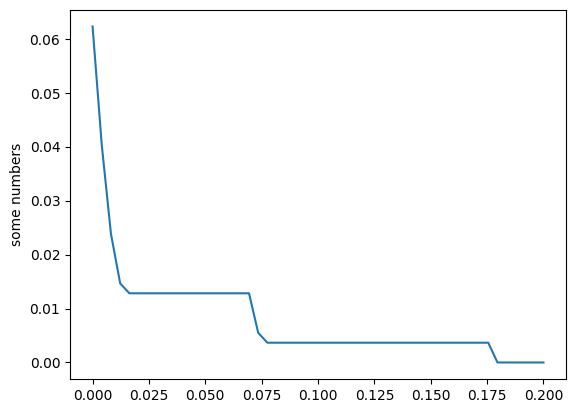

In [8]:
#let us investigate dependence of MAthews correlation coefficient on threshold selection
import numpy as np
eval_measure = []
th_range = np.linspace(0, 0.2, num=50)
for th in th_range:
    high_risk_suspects = thresholdSuspects(suspects, th)
    not_suspects = list((set(allAccounts) - set(high_risk_suspects)))
    conf_matrix = getConfusionTable(high_risk_suspects, not_suspects, compliant_accounts, noncompliant_accounts)
    tmp = conf_matrix['TP']/len(allAccounts)
    eval_measure.append(tmp)

#TODO: extend this with several measures

plt.plot(th_range, eval_measure)
plt.ylabel('some numbers')
plt.show()

#### Discussion

Having defined a simple rule to identify suspicious accounts, we can ask ourself several questions about the evaluation results:

1. What is the trade-off between statistical measures depending on the threshold?
2. Would a similar behavior occur if we varied the transaction amount interval?
3. If we added more rules, would our result improve?

### Anomaly detection based on local features

In [9]:
#((max(df.time) - min(df.time)).total_seconds() / (60*60))

In [10]:
#{id: attr['amount'] for id, attr in df.groupby(['source'])[['amount']].mean().to_dict(orient='index').items()}

In [11]:
#todo: you can add here there rule about close-to-round amounts, and then make the connection that the forest is extending the rule set
# also: you can set the threshold to optimal value

import networkx as nx

class feature_factory():
    
    def __init__(self, df):
        self.df = df
        self.allAccounts = df['source'].to_list() + df['target'].to_list()
        self.G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['amount', 'time'], create_using=nx.MultiDiGraph)

    def total_transactions(self):
        #for each account: a total number of transactions that
        return dict(self.G.degree())

    def avg_amount_sent_per_transaction(self):
        #for each account: average amount sent per time unit
        return {id: attr['amount'] for id, attr in df.groupby(['source'])[['amount']].mean().to_dict(orient='index').items()}


    def avg_amount_received_per_transaction(self):
        #for each account: average amount received per time unit
        return {id: attr['amount'] for id, attr in df.groupby(['target'])[['amount']].mean().to_dict(orient='index').items()}
    
    def unique_adjacency(self):
        #for each account: integer counts of accounts the received or sent a transaction
        unique_outdeg = {}
        for node, edges in self.G.adjacency():
            unique_outdeg[node] = len(edges.keys())
        return unique_outdeg
    
    def good_old_round_values_rule(self):
        #for each account: a boolean values indicating if our rule defined in previous section is true
        suspects = getSuspects(self.df)
        high_risk_suspects = thresholdSuspects(suspects, 0.1)
        return  {account: (account in high_risk_suspects) for account in self.allAccounts}

        

In [12]:
features = feature_factory(df)

f0 = features.total_transactions()
f1 = features.unique_adjacency()
f2 = features.good_old_round_values_rule()
f3 = features.avg_amount_sent_per_transaction()
f4 = features.avg_amount_received_per_transaction()

df_featurized = pd.DataFrame.from_records([f0,f1,f2,f3,f4]).transpose()
df_featurized.head(10)

,0,1,2,3,4
S7,188,79,False,6457.597197,4257.642857
I8,844,81,False,8489.653466,8631.201511
S0,172,87,False,5630.307522,2408.271186
I21,772,83,False,8365.601282,8466.467277
S9,177,79,False,6597.586667,2247.703704
I19,858,72,False,8537.591051,8515.723186
I12,803,80,False,8599.937318,8595.10146
S2,179,74,False,6142.33217,2976.712329
I3,830,76,False,8873.805572,8712.315251
S8,145,62,False,5828.506044,2614.203704


#### Normalization

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(df_featurized)
x = pd.DataFrame(data)

#### Clustering: Isolation Forest

In [14]:
#!pip install scikit-learn

In [15]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(df_featurized)
predictions = clf.predict(df_featurized)

In [16]:
suspects = []
not_suspects = []
for i, account in enumerate(df_featurized.index):
    if predictions[i] == -1:
        suspects.append(account)
    else:
        not_suspects.append(account)

getConfusionTable(suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 46, 'TN': 486, 'FP': 14, 'FN': 0}

In [17]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(2)
#Transform the data to 2d
df_components = pca.fit_transform(df_featurized)

#learn isolation forest model from 2d data
clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(df_components)
predictions = clf.predict(df_components)

df_results = df_featurized.copy()
df_results['prediction'] = predictions
types = []
for account in df_results.index:
    if account in lr.noncompliant_accounts:
        types.append('layering')
    elif account in rt.noncompliant_accounts:
        types.append('round_tripping')
    else:
        types.append('compliant')

df_results['behavior'] = types
df_results.head(15)

,0,1,2,3,4,prediction,behavior
S7,188,79,False,6457.597197,4257.642857,-1,round_tripping
I8,844,81,False,8489.653466,8631.201511,-1,round_tripping
S0,172,87,False,5630.307522,2408.271186,-1,round_tripping
I21,772,83,False,8365.601282,8466.467277,-1,round_tripping
S9,177,79,False,6597.586667,2247.703704,-1,round_tripping
I19,858,72,False,8537.591051,8515.723186,-1,round_tripping
I12,803,80,False,8599.937318,8595.10146,-1,round_tripping
S2,179,74,False,6142.33217,2976.712329,-1,round_tripping
I3,830,76,False,8873.805572,8712.315251,-1,round_tripping
S8,145,62,False,5828.506044,2614.203704,-1,round_tripping


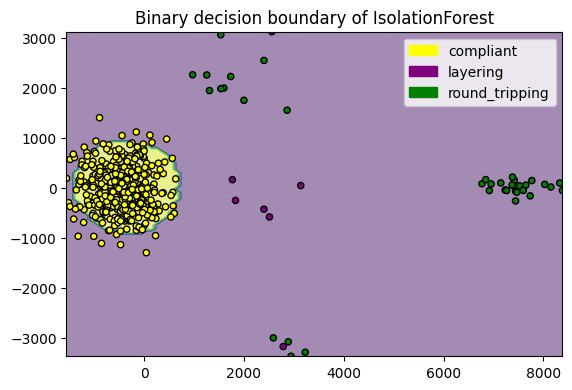

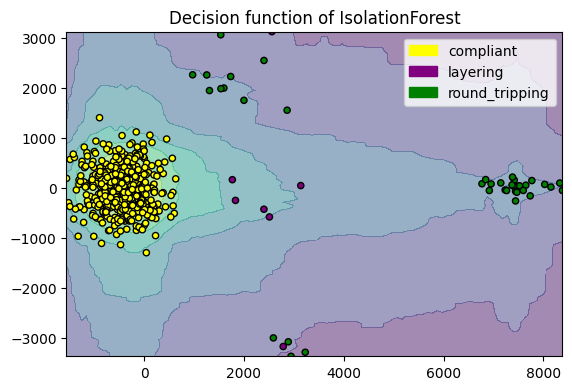

In [18]:
import matplotlib.patches as mpatches
d = {'compliant': 'yellow', 'layering': 'purple', 'round_tripping': 'green'}
for rm in ["predict", "decision_function"]:
    disp = DecisionBoundaryDisplay.from_estimator(clf, df_components, response_method=rm, alpha=0.5,)
    disp.ax_.scatter(df_components[:, 0], df_components[:, 1], c=list(map(d.get, df_results['behavior'])), s=20, edgecolor="k")
    if rm == 'predict': disp.ax_.set_title("Binary decision boundary of IsolationForest")
    if rm == 'decision_function': disp.ax_.set_title("Decision function of IsolationForest")
    plt.axis("square")
    plt.legend(handles = [mpatches.Patch(color=c, label=l) for l,c in d.items()])
    plt.ylim(min(df_components[:, 1]), max(df_components[:, 1]))
plt.show()

Lets look at what types of behavior were easier to identify

In [19]:
suspects = df_results.loc[(df_results['prediction'] == -1) & (df_results['behavior'] != 'round_tripping')].index.to_list()
not_suspects = df_results.loc[(df_results['prediction'] == 1) & (df_results['behavior'] != 'round_tripping')].index.to_list() 

getConfusionTable(suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 7, 'TN': 468, 'FP': 32, 'FN': 0}

In [20]:
suspects = df_results.loc[(df_results['prediction'] == -1) & (df_results['behavior'] != 'layering')].index.to_list()
not_suspects = df_results.loc[(df_results['prediction'] == 1) & (df_results['behavior'] != 'layering')].index.to_list() 

getConfusionTable(suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 39, 'TN': 468, 'FP': 32, 'FN': 0}

### Clustering based on structural knowledge

#### converting Multi-graph

In [ ]:
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['amount', 'time'], create_using=nx.MultiDiGraph)

#G_simple = nx.DiGraph()
#for u, v, data in G.edges(data=True):
#    if G_simple.has_edge(u, v):
#        G_simple[u][v]['weight'] += data['amount']  # Sum weights
#    else:
#        G_simple.add_edge(u, v, weight=data['amount'])

In [ ]:
communities = nx.community.louvain_communities(G, seed=123)

In [51]:
community_results = []
for i, com in enumerate(communities):
    ca_intersection_size = len(com.intersection(set(compliant_accounts)))
    lr_intersection_size = len(com.intersection(set(lr.noncompliant_accounts)))
    rt_intersection_size = len(com.intersection(set(rt.noncompliant_accounts)))
    community_results.append({'compliant accounts':ca_intersection_size, 'layering accounts':lr_intersection_size, 'round-tripping accounts':rt_intersection_size})

community_results = pd.DataFrame(community_results)

community_results.index.rename('community_id', inplace=True)

community_results.style.set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('font-size', '14px')]}]) \
    .background_gradient(cmap="Blues") 

,compliant accounts,layering accounts,round-tripping accounts
community_id,,,
0,0,0,38
1,0,7,1
2,500,0,0


In [23]:
#!pip install python-louvain
#!pip install cdlib